In [1]:
import numpy as np
import pandas as pd

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists


from music21 import midi, note, interval, pitch, serial, stream, instrument, meter, key, converter, serial
import itertools
import random


import nltk #for NLP
import string
import mchmm #for Markov models

In [2]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

In many musical cultures, the organisation of pitch is based on the selection of an alphabet of pitch material. In most of the Western classical tradition, the largest alphabet is formed by the *chromatic* scale, comprising a subdivision of the octave in 12 chromatic steps, the *semitones*. 

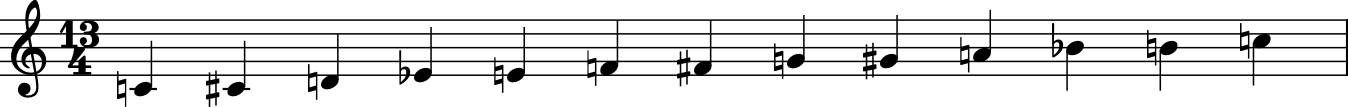

In [3]:
CHROMATIC = range(60, 60+13)
m = stream.Measure()
m.append([note.Note(pitch = x) for x in CHROMATIC])
m.show()

# Series

A specific ordering of the chromatic tones, a series, can be used as the building material for a composition, as proposed in the serialist twelve-tone technique. If we look at the incipit of Pierre Boulez' *Structures 1a* (https://www.youtube.com/watch?v=EmErwN02fX0), we can observe that each one of the two pianos plays sequentially all 12 tones from the chromatic set. 

<img src="boulez.png">

First, let's focus on the Piano I part. The pitch material is the following:

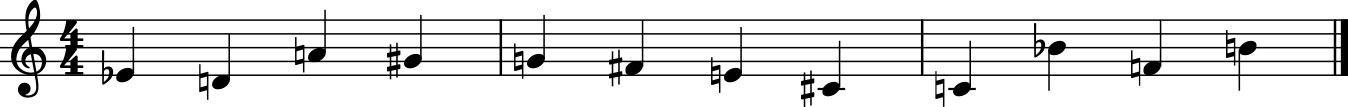

In [4]:
sb = serial.ToneRow([3, 2, 9, 8, 7, 6, 4, 1, 0, 10, 5, 11])
sb.show()

This is the series, or twelve-tone row, upon which the composition of the whole piece is based. Each segment of the piece comprises a cycle of the twelve-tone row or of a transformation thereof. For example, the notes played by the Piano II are obtained by inverting all intervals in the original row:

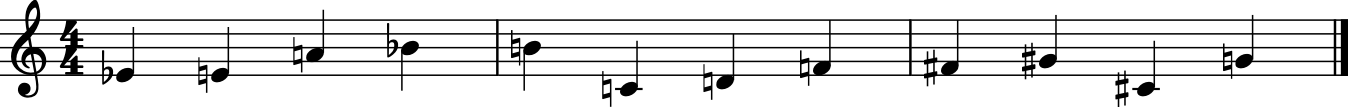

In [5]:
sb.originalCenteredTransformation('I',0).show()

Beyond inversion, other possible transformations of a twelve-tone row include the retrograde (i.e., playing the row backwards):

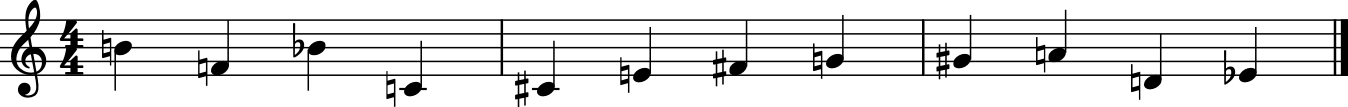

In [6]:
sb.originalCenteredTransformation('R',0).show()

and the retrograde inversion (i.e., playing the inversion of the original backwards):

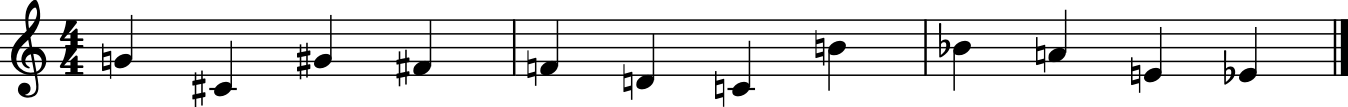

In [7]:
sb.originalCenteredTransformation('RI',0).show()

A row can also be transposed to start from a different note: here, for example, is the retrograde inverted form of the original row transposed 3 semitones up

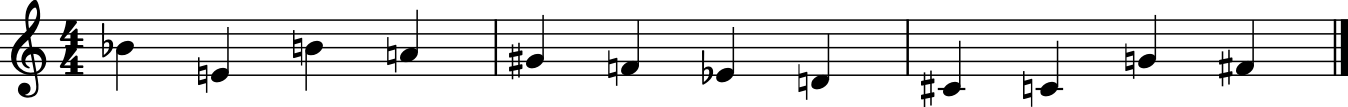

In [8]:
sb.originalCenteredTransformation('RI',3).show()

In *Structures*, pitch is not the only parameter of the music to be treated serially: the possible values of duration, intensity and articulation are also organised in rows, and the piece systematically cycles through the rows for each parameter. This technique is called *integral serialism*. Here are the rows for pitch, duration, intensity and articulation:

<img src="boulezseries.png">

With *Structures*, Boulez wanted to *eradicate from my vocabulary absolutely every trace of the conventional, whether it concerned figures and phrases, or development and form; I then wanted gradually, element after element, to win back the various stages of the compositional process, in such a manner that a perfectly new synthesis might arise, a synthesis that would not be corrupted from the very outset by foreign bodies – stylistic reminiscences in particular* (Boulez, 1986). The integral serialist approach was the first step of this attempt to develop an "unbiased" compositional process.

# Scales and Modes

Starting from the chromatic scale, other scales can be formed by selecting a subset of pitches, thus skipping some of the chromatic steps. Such a scale can be identified by specifying the intervals, i.e. the number of semitones, that separate consecutive pitches, as well as the *root*, i.e. the starting note.

In [9]:
def select_from_chromatic(intervals, root = 'C'):
    #Selects pitches from a chromatic collection based on a set of intervals
    return [note.Note(pitch = pitch.Pitch(root).midi + x) for x in [0]+[sum(intervals[:i+1]) for i in range(len(intervals))]]

For example, a very commong scale in Western classical music is the major scale:

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


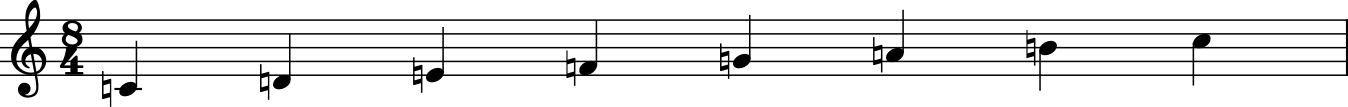

In [10]:
MAJOR = [2, 2, 1, 2, 2, 2, 1]
m = stream.Measure()
m.append(select_from_chromatic(MAJOR))
play(m)
m.show()

Note that the intervals in a major scale are not all the same: between the third and the fourth note, as well as between the seventh and the eigth (which is equivalent to the first under octave equivalence) there is an interval of just 1 semitone. 

We can obtain other *modes* that are based on the same selection of itnervals by rotating the list of intervals, and changing the root.

In [11]:
def rotate_list(l, n):
    #rotate list l by n steps
    return l[n:] + l[:n]

def select_mode(mode, root, scale = MAJOR):
    #select a mode based on a root
    return select_from_chromatic(rotate_list(scale, mode), root)

For example, here is the so-called "phrygian" mode, which shares all pitches with the major scale, but with a different ordering of intervals (starting from root E):

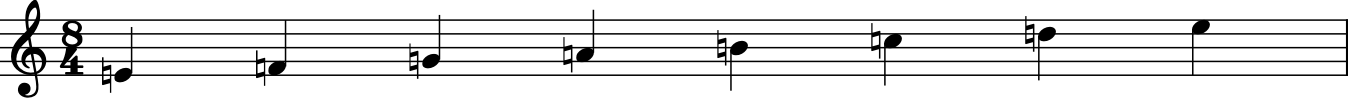

In [12]:
phrygian = select_mode(2, 'E')
m = stream.Measure()
m.append(phrygian)
play(m)
m.show()

The chromatic subdivision of the octave in 12 semitones is particularly relevant in the Western classical tradition. However, different cultures draw their pitch materials from different scales, whose pitches do not correspond to any of the chromatic tones. Here are two examples from the Javanese tradition, the *pelog* and the *slendro* scale. Note that, while the *pelog* scale results in an unequal subdivision of the octave (similarly to the Western diatonic scale), the *slendro* scale divides the octave in roughly equal intervals. 

<img src="scales.png">

<video controls src="gamelan.mp4" />

# Dividing the octave

In [13]:
def fractal_division(ratio, smallest, interval = 1, displace = 0):
    if interval >= smallest:
        splits = []
        split = [interval * ratio, interval * (1-ratio)]
        
        onset = displace
        for i in split:
            splits += fractal_division(ratio, smallest, interval = i, displace = onset)
            onset += i
        
        return splits
        
    else:
        return [interval+displace]

In [14]:
def scale_from_division(division, span,  root):
    new_scale = [note.Note(pitch = root)] + [note.Note() for _ in division]
    for i in range(len(division)):
        new_scale[i+1].pitch.ps = root + division[i] * span
    return new_scale
    


In [15]:
golden = 2/(1 + 5 ** 0.5)
golden_division = fractal_division(golden, 1/12)
m = stream.Measure()
m.append(scale_from_division(golden_division, 12, 60))
play(m)

# Pitch class and Pitch-class sets

Pitch classes are the equivalence classes in pitch-space under octave equivalence. E.g.:

In [85]:
note.Note("F8").pitch.pitchClass == note.Note("F4").pitch.pitchClass

True

The interval between two pitch classes is not well-defined: for example, if we consider pitch-classes C and G#, we can have the G# lying 8 semitones above the C...

In [42]:
C = note.Note('C4')
highGis = note.Note('G#4')
ChighGis = interval.Interval(noteStart = C, noteEnd = highGis)
ChighGis.semitones

8

or the one 4 semitones below the C:

In [41]:
lowGis = note.Note('G#3')
lowGisC = interval.Interval(noteStart = lowGis, noteEnd = C)
lowGisC.semitones

4

We define instead the interval class between two pitch classes as the smallest interval between representatives of the two classes:

In [114]:
n1 = note.Note('C')
n2 = note.Note('G#')
n1n2 = interval.Interval(noteStart = n1, noteEnd = n2)
n1n2.intervalClass

4

A generalisaion of scales are pitch-class sets, which are unordered collections of pitch classes. Each pitch class in a pitch-class set may be identified by a number from 0 to 11, 0 corresponding to the pitch class of a C. 

In [98]:
pitchClassSet = {0, 3, 5}

def notes_from_pitchClassSet(pitchClassSet, transpose = 0):
    #Returns list of notes based on a pitchClassSet and a transposition (default, start on C)
    return [note.Note(pitch = pitchClass+transpose) for pitchClass in pitchClassSet]

notes_from_pitchClassSet(pitchClassSet)

[<music21.note.Note C>, <music21.note.Note E->, <music21.note.Note F>]

In order to characterize a pitch class set, we can look at the intervals formed by the members of the set. In particular, we consider all possible interval classes between any two members of the set. The interval vector of a pitch class is a 6-vector whose i-th component reflects how many interval classes of size i are to be found among all the possible pairings of elements of the set.

In [18]:
def intervalVector(notes):
    #Compute the interval vector of a list of notes
    vector = {i+1:0 for i in range(6)}
    pairs = itertools.combinations(notes, 2)
    for pair in pairs:
        intClass = interval.Interval(pair[0], pair[1]).intervalClass
        vector[intClass] += 1
    return vector

Interval vectors capture an important aspect of the compositional possibilities that arise when adopting a certain pitch-class set as the pitch alphabet for a piece (or a portion thereof): they tell us what are the possible intervals that can be formed if those pitches are played one after the other (melodically) or simultaneously (harmonically).

Algebraic properties of pitch-class sets, such as their invariances under transformations, are a fertile terrain for creative and algorithmic exploration. If you are interested, you can read more on musical set theory, e.g. starting from this simple introduction https://musictheory.pugetsound.edu/mt21c/SetTheory.html.

# Polyphony

Up to this point, we have generated individual melodies. In a piece of music, melodies may interact with one another, for example by playing simultaneously. This results in polyphony. 

As a simple example, we can build canons by shifting a melody against itself. The parameters of the canon are the delay of the *comes*, i.e. how much later compared to the *dux* it starts, and its transposition w.r.t. the *dux*.

In [16]:
def canon_from_theme(theme, delay, transposition):
    #Generates a canon based on a theme, after setting the delay and the transposition of the comes
    
    dux = stream.Part() #set dux part
    comes = stream.Part() #set comes part

    dux.append(theme.flat.notesAndRests) #asign notes and rests from the theme to the dux
    
    #transposed theme for the comes
    transposed_theme = [x.transpose(interval.ChromaticInterval(transposition)) for x in theme.flat.notes]
    
    #append transposed theme to the comes, after a rest of duration delay
    comes.append([note.Rest(quarterLength = delay)]+transposed_theme)

    #set the score for the canon
    canon = stream.Score()
    canon.append(comes) #populate the score with the comes
    canon.append(dux) #populate the score with the dux
    
    #assign different instruments to the two parts, to make them more distinguishable
    canon[0].insert(0, instrument.Violin())  
    canon[1].insert(0, instrument.Violoncello())
    

    return canon

If we use the full chromatic collection as our theme, the canon will sound for example like this:

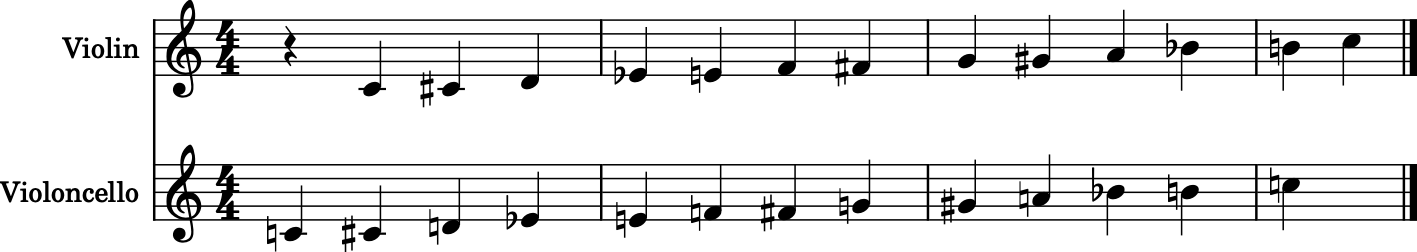

In [17]:
chromatic = stream.Stream()
chromatic.append([note.Note(pitch = x) for x in CHROMATIC])
chromatic_canon = canon_from_theme(chromatic, 1, 0)
chromatic_canon.show()
play(chromatic_canon)

In [18]:
def get_simultaneity(score, offset):
    notes = []
    for part in score.parts:
        notes += list(part.flat.getElementsByOffset(offset).notes)
    
    return notes 

def get_simultaneity_interval(score, offset):
    simultaneity = get_simultaneity(score, offset)
    return abs(interval.Interval(noteStart = simultaneity[0], noteEnd = simultaneity[1]).semitones)%12

    
def interval_histogram(score):
    harmonic_intervals = []
    for offset in set([x.offset for x in score.flat.elements]):
        simultaneity = get_simultaneity(score, offset)
        if len(simultaneity)>1:
            harmonic_intervals += [get_simultaneity_interval(score, offset)]
    harmonic_intervals.sort()        
    return(Counter(harmonic_intervals))

In [19]:
interval_histogram(chromatic_canon)

Counter({1: 12})

Since the theme only comprises one type of (horizontal) interval, the semitone, also the vertical intervals that are formed between simultaneous notes in the *dux* and the *comes* are all equal. We can change the interval by choosing a different delay or transposition for the comes, but it will always be only one interval. If we choose a more varied theme, we also get more varied simultaneities:

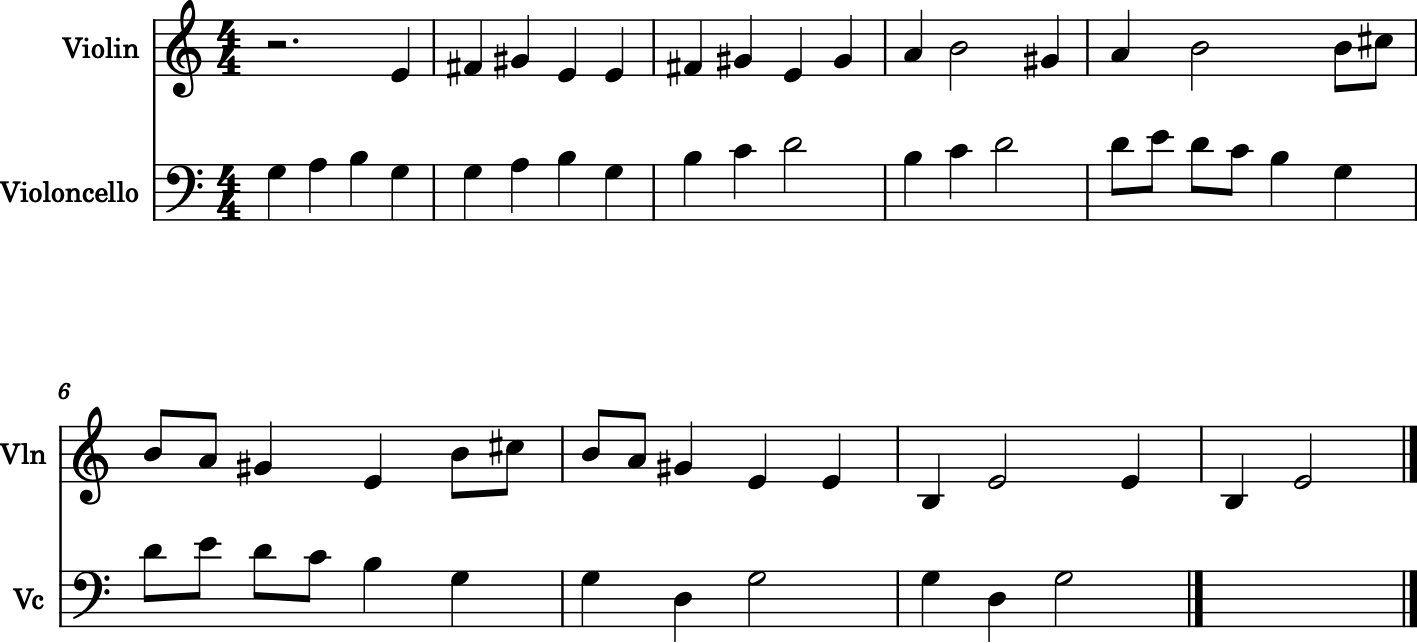

In [20]:
subject = converter.parse('frere_jacques.mid')
canon3 = canon_from_theme(subject, 3, 9)
canon3.show()

In [21]:
play(canon3)

In [22]:
interval_histogram(canon3)

Counter({2: 2, 4: 4, 5: 3, 6: 2, 7: 2, 8: 1, 9: 5, 10: 1, 11: 3})

Note how many different intervals are formed between simultaneous notes. In particular, there are many dissonant ones (1, 2, 10, or 11 semitones). If we choose a different delay and transposition, we can change the intervals that are formed, as well as the overall sonority:

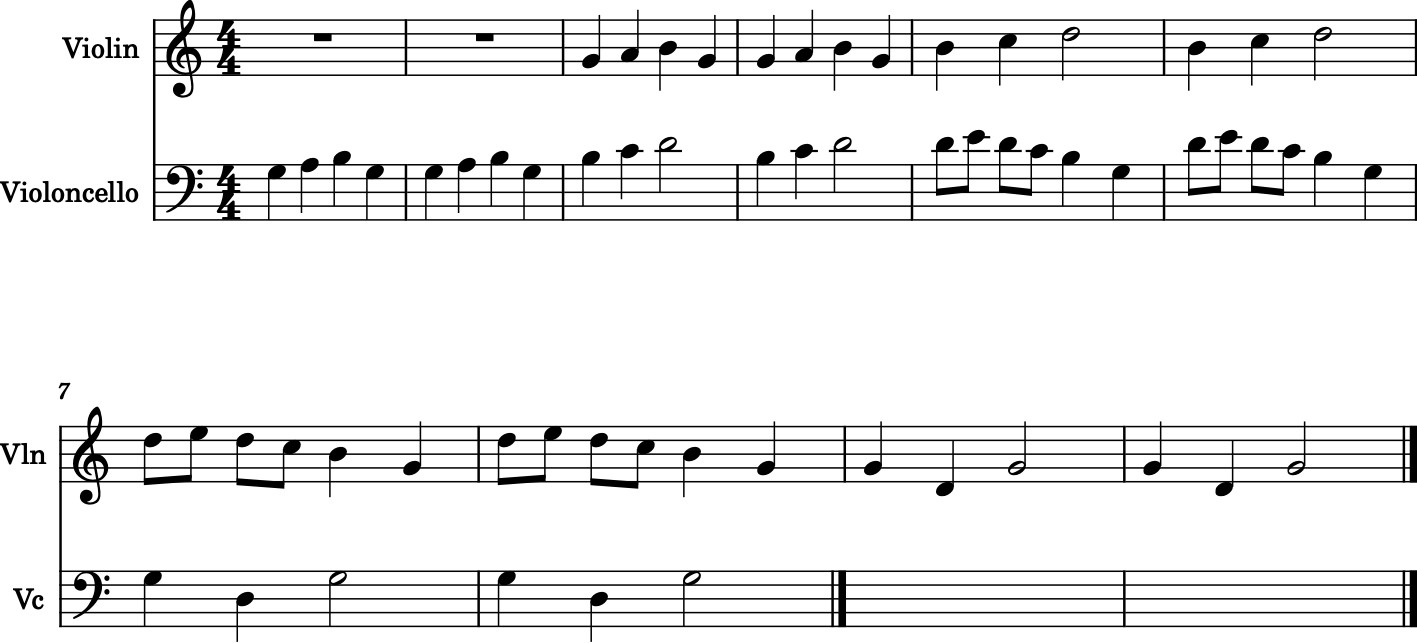

In [270]:
canon8 = canon_from_theme(subject, 8, 12)
canon8.show()

In [272]:
play(canon8)

In [271]:
interval_histogram(canon8)

Counter({0: 2, 3: 2, 4: 2, 7: 2, 8: 2, 9: 6, 10: 2})